<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/02_LangGraph_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!pip install -r requirement.txt

Tool Management

In [92]:
def add_two_number(a:int,b:int) -> int:
    """
    This function add two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Sum of two valus
    """
    int_a = int(a)
    int_b = int(b)

    return int_a+int_b

Model

In [93]:
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict,Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

LLM With Tools

In [94]:
from langchain_groq import ChatGroq
from google.colab import userdata

llm = ChatGroq(
    model="deepseek-r1-distill-llama-70b",
    api_key= userdata.get("groq_key")
)

llm_bind_tools = llm.bind_tools([add_two_number])

Invoke LLM

In [95]:
invoke_llm = llm_bind_tools.invoke("add two_numbe 2 and 5")

In [96]:
invoke_llm.tool_calls

[{'name': 'add_two_number',
  'args': {'a': 2, 'b': 5},
  'id': 'bxd0mwg7g',
  'type': 'tool_call'}]

LangGraph Tool Calling

In [97]:
def llm_tool_calling(state: State) -> State:
    """
    This function is called to invoke the LLM with tools.

    :param state: The current state containing messages
    :return: Updated state with the response from the LLM
    """
    response = llm_bind_tools.invoke(state["messages"])
    state["messages"].append(response)
    return state

In [98]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [99]:
graph = StateGraph(State)

In [100]:
graph.add_node("llm", llm_tool_calling)
graph.add_node("tools", ToolNode(tools=[add_two_number]))

In [101]:
graph.add_edge(START, "llm")
graph.add_conditional_edges("llm", tools_condition)
graph.add_edge("tools", END)

In [102]:
graph_builder = graph.compile()

Print and verify the created Graph

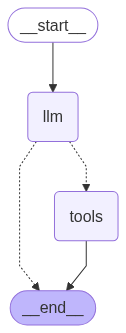

In [103]:
from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

Invoke LLM

In [104]:
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
state = State(messages= HumanMessage(content="Add two number 2 and 5"))

In [105]:
output = graph_builder.invoke(state)

In [106]:
import pprint
for msg in output['messages']:
     msg.pretty_print()

================================ Human Message =================================

Add two number 2 and 5
================================== Ai Message ==================================
Tool Calls:
  add_two_number (sc1zmas01)
 Call ID: sc1zmas01
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: add_two_number

7


We can also chain one or more tools togethor

In [107]:
def subtract_two_number(a:int,b:int) -> int:
    """_summary_
     This function subtract two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: Subtract two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a-b

def multiply_two_number(a:int,b:int) -> int:
    """_summary_
     This function multiply two numbers

    Args:
        a (int): Paramater a of type int
        b (int): Paramater b of type int

    Returns:
        int: multiply two valus
    """
    int_a = int(a)
    int_b = int(b)

    return a*b


In [108]:
multiple_tool_graph = StateGraph(State)

In [109]:
multiple_tool_graph.add_node("llm", llm_tool_calling)
multiple_tool_graph.add_node("tools", ToolNode(tools=[add_two_number,subtract_two_number,multiply_two_number]))

In [110]:
multiple_tool_graph.add_edge(START, "llm")
multiple_tool_graph.add_conditional_edges("llm", tools_condition)
multiple_tool_graph.add_edge("tools", END)

In [111]:
graph_builder_multiple_tools = multiple_tool_graph.compile()

In [112]:
state_message = State(messages= HumanMessage(content="Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5"))

In [115]:
result = graph_builder_multiple_tools.invoke(state_message)

In [116]:
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Add two number 2 and 5 and then multiply it with 10 and subtarct it with 5
================================== Ai Message ==================================

To solve the problem step by step:

1. **Add two numbers (2 and 5):**
   \[
   2 + 5 = 7
   \]
2. **Multiply the result by 10:**
   \[
   7 \times 10 = 70
   \]
3. **Subtract 5 from the product:**
   \[
   70 - 5 = 65
   \]

The final result is **65**.
